# Proyek Klasifikasi Gambar: "Honkai: Star Rail" Map
- **Nama:** Muhammad Faisal Aktsa
- **Email:** fslfaisal17@gmail.com
- **ID Dicoding:** fslmc17

## Import Semua Packages/Library yang Digunakan

In [22]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
import json
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

## Data Preparation

### Data Loading

In [4]:
class1 = "star_rail/dataset/herta/"
class2 = "star_rail/dataset/jarilo/"
class3 = "star_rail/dataset/luofu/"

train_dir = "star_rail/train/"
test_dir = "star_rail/test/"
val_dir = "star_rail/val/"

### Data Preprocessing

#### Split Dataset

In [ ]:
# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
# Create directories if they don't exist
os.makedirs(os.path.join(train_dir, "herta"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "jarilo"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "luofu"), exist_ok=True)

os.makedirs(os.path.join(test_dir, "herta"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "jarilo"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "luofu"), exist_ok=True)

os.makedirs(os.path.join(val_dir, "herta"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "jarilo"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "luofu"), exist_ok=True)

In [ ]:
def split_dataset(class_path, class_name):

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split into train and temp (test + val)
    train_files, temp_files = train_test_split(images, train_size=train_ratio, random_state=42)

    # Split temp into test and val
    test_files, val_files = train_test_split(temp_files, test_size=val_ratio/(val_ratio + test_ratio), random_state=42)

    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_dir, class_name, file)
        shutil.copy(src, dst)

    print(f"Class {class_name}:")
    print(f"  Total images: {len(images)}")
    print(f"  Training set: {len(train_files)}")
    print(f"  Test set: {len(test_files)}")
    print(f"  Validation set: {len(val_files)}")

In [ ]:
split_dataset(class1, "herta")
split_dataset(class2, "jarilo")
split_dataset(class3, "luofu")

print("Dataset splitting completed!")

Class herta:
  Total images: 500
  Training set: 350
  Test set: 75
  Validation set: 75
Class jarilo:
  Total images: 500
  Training set: 350
  Test set: 75
  Validation set: 75
Class luofu:
  Total images: 500
  Training set: 350
  Test set: 75
  Validation set: 75
Dataset splitting completed!


#### Image Processing

In [5]:
# Image processing parameters
TARGET_SIZE = (320, 180)  # Reduced from original size for efficiency
BATCH_SIZE = 32
CHANNELS = 3

In [6]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

In [7]:
# Validation and test generators (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Create data generators

#train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

#test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1050 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


## Modelling

In [9]:
#Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

C:\FslMc\pythonML\Star-Rail-Map-Classification\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compiling
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, early_stop, reduce_lr, csv_logger]

In [11]:
# parameters
EPOCHS = 50

In [ ]:
# Train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5282 - loss: 1.0595 - val_accuracy: 0.3393 - val_loss: 1.1332 - learning_rate: 0.0010
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6875 - loss: 0.7524

C:\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.6875 - loss: 0.7524 - val_accuracy: 0.3393 - val_loss: 1.1358 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6747 - loss: 0.7544 - val_accuracy: 0.3304 - val_loss: 1.3531 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7188 - loss: 0.8591 - val_accuracy: 0.3304 - val_loss: 1.3628 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7264 - loss: 0.6291 - val_accuracy: 0.3348 - val_loss: 1.6750 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6562 - loss: 0.8080 - val_accuracy: 0.3348 - val_loss: 1.6616 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7496 - loss: 0.6287 - val_accuracy: 0.3348 - val_loss: 1.7793 - learning_rate: 5.0000e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7500 - loss: 0.6670 - val_accuracy:

## Evaluasi dan Visualisasi

In [ ]:
# Plot training history
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

In [ ]:
# Evaluate on validation set
def evaluate_model(model, val_generator):
    y_true = val_generator.classes
    y_pred = np.argmax(model.predict(val_generator), axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

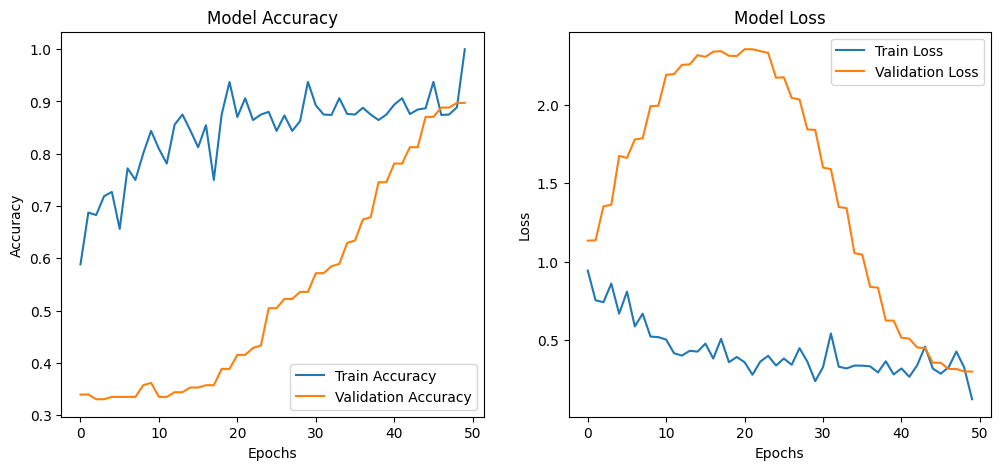

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step


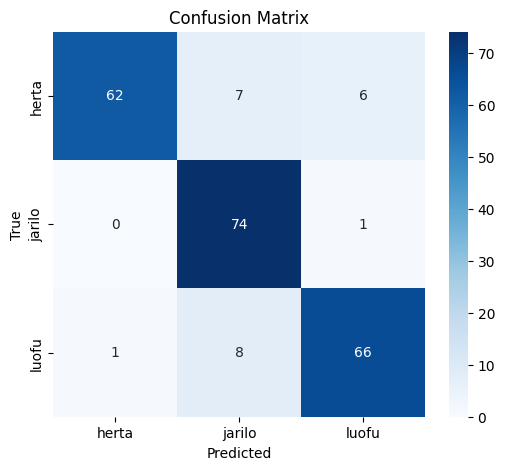

Classification Report:
              precision    recall  f1-score   support

       herta       0.98      0.83      0.90        75
      jarilo       0.83      0.99      0.90        75
       luofu       0.90      0.88      0.89        75

    accuracy                           0.90       225
   macro avg       0.91      0.90      0.90       225
weighted avg       0.91      0.90      0.90       225



In [ ]:
plot_training_history(history)
evaluate_model(model, val_generator)

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f"Model Accuracy on Validation Set: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.8762 - loss: 0.3281
Model Accuracy on Validation Set: 0.8978


## Konversi Model

In [14]:
best_model = keras.models.load_model('best_model.keras')

In [6]:
# Define directories
os.makedirs('/tfjs_model/', exist_ok=True)
os.makedirs('/tflite/', exist_ok=True)
os.makedirs('/saved_model/', exist_ok=True)

In [13]:
# Convert to SavedModel
model.save('savedmodel.keras')
print("SavedModel saved successfully.")

SavedModel saved successfully.


In [16]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
tflite_model = converter.convert()

# Save TFLite model
with open('/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save label file (assuming 3 classes)
labels = ['Class1', 'Class2', 'Class3']
with open('/tflite/label.txt', 'w') as f:
    f.write('\n'.join(labels))

print("TFLite model saved successfully.")

TFLite model saved successfully.


In [6]:
import tensorflowjs as tfjs
# Convert to TensorFlow.js format
tfjs.converters.save_keras_model(model, '/tfjs_model')

print("TensorFlow.js model saved successfully.")

failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved successfully.


## Inference (Optional)

In [20]:
modeld = tf.keras.models.load_model('savedmodel.keras')

C:\FslMc\pythonML\Star-Rail-Map-Classification\env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Class: herta
Confidence: 36.60%


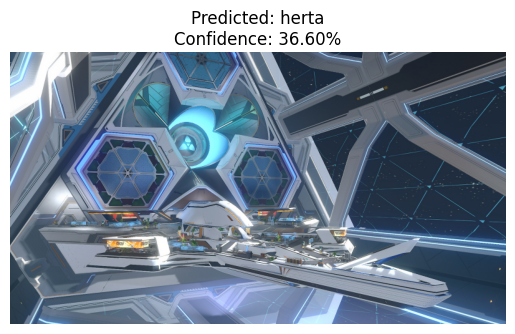

In [25]:
class_names = ['herta', 'jarilo', 'luofu']

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Preprocess image for model prediction
    """
    # Load and resize image
    img = load_img(image_path, target_size=target_size)
    # Convert to array and normalize
    img_array = img_to_array(img) / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(image_path, model=model):
    """
    Make prediction on a single image
    """
    # Preprocess image
    processed_img = preprocess_image(image_path)
    
    # Make prediction
    predictions = modeld.predict(processed_img)
    
    # Get class and confidence
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    class_name = class_names[predicted_class]
    
    return class_name, confidence

def display_prediction(image_path, class_name, confidence):
    """
    Display image with prediction results
    """
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()

# Example usage
test_image_path = "test_inference/test.png"

# Make prediction
class_name, confidence = predict_image(test_image_path)

# Display results
print(f"Predicted Class: {class_name}")
print(f"Confidence: {confidence:.2%}")
display_prediction(test_image_path, class_name, confidence)

# Batch prediction for multiple images
def batch_predict(image_folder):
    """
    Predict on all images in a folder
    """
    results = []
    valid_extensions = ['.jpg', '.jpeg', '.png']
    
    for filename in os.listdir(image_folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                class_name, confidence = predict_image(image_path)
                results.append({
                    'image': filename,
                    'class': class_name,
                    'confidence': confidence
                })
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    return results


That is a correct answer!